In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection
!unzip car-object-detection.zip

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 94% 105M/112M [00:00<00:00, 127MB/s] 
100% 112M/112M [00:00<00:00, 125MB/s]
Archive:  car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  

In [2]:
import pandas as pd

df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281,187,327,223
1,vid_4_10000.jpg,15,187,120,236
2,vid_4_10040.jpg,239,176,361,236
3,vid_4_10020.jpg,496,172,630,231
4,vid_4_10060.jpg,16,186,132,238
...,...,...,...,...,...
554,vid_4_9860.jpg,0,198,49,236
555,vid_4_9880.jpg,329,156,536,250
556,vid_4_9900.jpg,0,168,141,239
557,vid_4_9960.jpg,487,172,616,228


In [3]:
df.max(axis = 0)

image    vid_4_9980.jpg
xmin                645
ymin                208
xmax                676
ymax                308
dtype: object

In [4]:
import torch
from torchvision import transforms
from PIL import Image

def get_tensor_image_from_path(path):
    img = Image.open(path).resize((256, 256))
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)

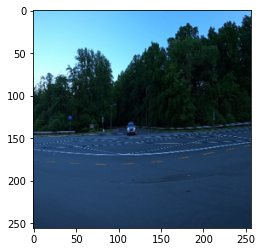

In [5]:
import matplotlib.pyplot as plt

sample_image_tensor = get_tensor_image_from_path('/content/data/training_images/vid_4_1000.jpg')
plt.imshow(sample_image_tensor.permute(1,2,0));

Image Shape: (380, 676, 3)


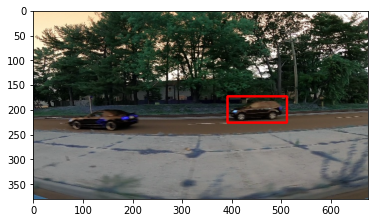

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob 
import random 

DIR = '/content/data/training_images/'
row = dict(df.iloc[103])
img = cv2.imread(DIR + row['image'])
print('Image Shape:', img.shape)
xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
plt.imshow(img)


In [11]:
def convert_tensor_and_frame(position, DIR = '/content/data/training_images/'):
    row = dict(df.iloc[position])
    img = cv2.imread(DIR + row['image'])
    #print('Image Shape:', img.shape)
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    tensor_image = get_tensor_image_from_path(DIR + row['image'])

    xmin *= (tensor_image.shape[1] / img.shape[1])
    xmax *= (tensor_image.shape[1] / img.shape[1])
    ymin *= (tensor_image.shape[2] / img.shape[0])
    ymax *= (tensor_image.shape[2] / img.shape[0])

    return tensor_image, xmin, xmax, ymin, ymax
    #cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
    #plt.imshow(img)


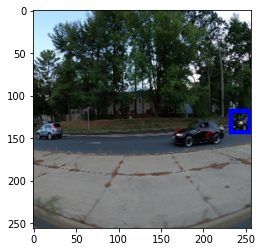

In [12]:
from torchvision.utils import draw_bounding_boxes
import torchvision
tensor_image, xmin, xmax, ymin, ymax = convert_tensor_and_frame(100)


boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=int)
colors = ["blue"]
int_tensor = (255 * tensor_image).type(torch.LongTensor)
int_tensor = torchvision.transforms.ConvertImageDtype(torch.uint8)(tensor_image)

result = draw_bounding_boxes(int_tensor, boxes, colors=colors, width=5)
plt.imshow(result.permute(1,2,0));

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
from torch.utils.data import Dataset, DataLoader

def SQuare(xmin, xmax, ymin, ymax):
    return (ymax - ymin) * (xmax - xmin)

def IoU(xmin, xmax, ymin, ymax, Xmin, Xmax, Ymin, Ymax):
    x_in_min = max(xmin, Xmin)
    x_in_max = min(xmax, Xmax)
    y_in_min = max(ymin, Ymin)
    y_in_max = min(ymax, Ymax)

    intersection_square = SQuare(x_in_min, x_in_max, y_in_min, y_in_max)
    union_square = SQuare(xmin, xmax, ymin, ymax) +  SQuare(Xmin, Xmax, Ymin, Ymax) - intersection_square

    return intersection_square / union_square

class ImageDetectionDataset(Dataset):
    def __init__(self, df, DIR, delta = 2):
        self.df = df
        self.DIR = DIR
        self.augmented_list = [] # (path, xcenter, ycenter, w, h, confidence)
        self.masks = []
        for data_pos in range(self.df.shape[0]):
            for position in range(4):
                for i in range(-delta, delta):
                    image_path = self.DIR + df['image'].iloc[data_pos]
                    frame = [df['xmin'].iloc[data_pos], df['xmax'].iloc[data_pos], df['ymin'].iloc[data_pos], df['ymax'].iloc[data_pos]]
                    frame[position] += i
                    confidence = IoU(df['xmin'].iloc[data_pos], df['xmax'].iloc[data_pos], df['ymin'].iloc[data_pos], df['ymax'].iloc[data_pos],
                                     frame[0], frame[1], frame[2], frame[3]) 
                    x_center = (frame[0] + frame[1]) / 2
                    y_center = (frame[2] + frame[3]) / 2 
                    w = frame[1] - frame[0]
                    h = frame[3] - frame[2]

                    x_center *= (256 / 676)
                    w *= (256 / 676)
                    y_center *= (256 / 380)
                    h *= (256 / 380)

                    self.augmented_list.append((image_path, x_center, y_center, w, h, confidence))
                    expected_mask = torch.zeros((8, 8)).to(device)

                    for i in range(8):
                        for j in range(8):
                            expected_mask[i][j] =  IoU(i * 32, (i * 32) + 31, j * 32, (j * 32) + 31,
                                    x_center - w / 2,  x_center + w / 2, 
                                    y_center - h / 2, y_center + w / 2)

                    self.masks.append(expected_mask)

    def __len__(self):
        return len(self.augmented_list)

    def __getitem__(self, position):
        image_tensor = get_tensor_image_from_path(self.augmented_list[position][0]).to(device)
        target_tensor = torch.FloatTensor([self.augmented_list[position][1], 
                                           self.augmented_list[position][2],
                                           self.augmented_list[position][3],
                                           self.augmented_list[position][4],
                                           self.augmented_list[position][5]]).to(device)
        
        return {'X' : image_tensor, 'y': target_tensor, 'mask' : self.masks[position]}


In [16]:
dataset = ImageDetectionDataset(df, '/content/data/training_images/', 5)
dataset[0]['X'].shape, dataset[0]['y'].shape

(torch.Size([3, 256, 256]), torch.Size([5]))

In [17]:
len(dataset)

22360

In [18]:
train_loader = DataLoader(dataset, batch_size = 50)

# VGG architecture:

In [19]:
import torchvision.models as models

model = models.vgg19(pretrained=True).features.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [20]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [21]:
for batch in train_loader:
    print(model(batch['X']).shape)
    break

torch.Size([50, 512, 8, 8])


In [26]:
import torch.nn as nn

class YOLO_vgg(nn.Module):
    def __init__(self, cnt_freeze = 7):
        super().__init__()
        self.pretrained_model =  models.vgg19(pretrained=True).features.to(device)
        self.cnt_freeze = cnt_freeze
        for param in self.pretrained_model.parameters():
            param.requires_grad_(False)
            self.cnt_freeze -= 1
            if self.cnt_freeze == 0:
                break
        self.neck = nn.Sequential(
            nn.Conv2d(512, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 32, 3,1,1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 11, 3, 1, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image):
        hidden = self.pretrained_model(input_image)
        hidden = self.neck(hidden) # batch_size * 5 * 8 * 8
        hidden[:, 4, :, :] = self.sigmoid(hidden[:, 4, :, :])
        hidden[:, 9, :, :] = self.sigmoid(hidden[:, 9, :, :])
        hidden[:, 10, :, :] = self.sigmoid(hidden[:, 10, :, :])
        return hidden

In [27]:
model = YOLO_vgg().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
criterion_confidence = nn.BCELoss()

In [28]:
from tqdm.auto import tqdm 

num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    sum_loss, cnt_loss = 0, 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(batch['X'])

        x, y = batch['y'][:, 0] // 32, batch['y'][:, 1] // 32

        x = x.to(torch.long)
        y = y.to(torch.long)
        predicted = torch.zeros((output.shape[0], output.shape[1])).to(device)
        for i in range(output.shape[0]):
            predicted[i, :] = output[i, :, x[i], y[i]]
        loss = 100 * criterion(predicted[:, 0:4], batch['y'][:, 0:4]) + criterion_confidence(predicted[:, 4], batch['y'][:, 4])
        loss += 100 * criterion(predicted[:, 5:9], batch['y'][:, 0:4]) + criterion_confidence(predicted[:, 9], batch['y'][:, 4])

        loss += criterion_confidence(output[:, 10, :, :], batch['mask'])
        sum_loss += loss.item()
        cnt_loss += 1
        if cnt_loss % 20  == 0:
            print(sum_loss / cnt_loss)
        loss.backward()
        optimizer.step()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  # This is added back by InteractiveShellApp.init_path()


41665898.46875
21816520.8234375
14823973.309895834
11267300.712695312
9463296.30765625
8227086.444921875
7342090.601004465
6678009.678417969
6186349.876649305
5839854.145859375
5439718.935369318
5130333.110286458
4871349.415024038
4633058.10859375
4437339.372083333
4258498.9835449215
4052591.664108456
3850209.4521701387
3666497.763096217
3504524.2835351564
3346437.3186662947
3200184.7950461647


  0%|          | 0/448 [00:00<?, ?it/s]

147926.69814453126
156386.55473632814
176268.0831705729
168918.7073486328
160003.71455078124
158275.01625976563
154007.4841936384
145455.08406982422
137723.28958333333
131588.50779296874
127744.51305930398
123950.66060384114
119335.89627403846
114727.41332310268
111270.67409505208
108735.29337768555
105366.0268928079
101984.80110405816
101168.85376490543
101292.59167236328
99256.01768740699
96930.36068004262


  0%|          | 0/448 [00:00<?, ?it/s]

43537.031005859375
55640.732849121094
76074.44908040365
73670.19608764649
71169.08885253906
70681.30920817057
70720.49981515067
65772.52688293457
62440.92380371094
58833.36341552735
56542.8216463956
54127.038065592445
51994.9948054387
49870.34182652065
48405.361212565105
47175.31099090576
45824.18590303309
44539.44095594618
45144.88081568668
46469.69082763672
45682.06782459078
44973.46454856179


  0%|          | 0/448 [00:00<?, ?it/s]

25848.496044921874
26848.5201171875
48358.627278645836
49273.95007324219
51571.891220703124
53058.13681640625
55728.067222377234
52211.82593688965
49412.34527180989
46277.14709960938
44392.01954456676
42451.474763997394
40668.32995229868
38893.27557896206
37777.924977213544
36817.348808288574
35816.20818732766
34675.264450412324
35078.03554751747
37048.88320373535
36827.16019170852
36538.355649081146


  0%|          | 0/448 [00:00<?, ?it/s]

26299.15231933594
22214.140478515626
40811.6734375
44464.77283935547
50422.919140625
50789.7235921224
51952.72547433036
48872.41363220215
46121.698231336806
43289.76587158203
41606.30793235085
39892.25229899088
38139.57354079026
36302.93933279855
35273.21694010417
34466.35207824707
33373.4681439568
32286.454982503255
32659.77644556949
34369.7447668457
34208.582531738284
33814.339629017224


In [49]:
def inference(path, lim = 0.0): 
    image_tensor = get_tensor_image_from_path(path).to(device).unsqueeze(0)
    output = model(image_tensor)# 0, 10, 8, 8
    for i in range(8):
        for j in range(8):
            confidence = output[0, 4, i, j].item() * output[0, 10, i, j].item()
            if confidence > lim:
                x_center, y_center, w, h = output[0, 0, i, j].item(), output[0, 1, i, j].item(), output[0, 2, i, j].item(), output[0, 3, i, j].item()
                yield ( x_center, y_center, w, h)
            confidence = output[0, 9, i, j].item() * output[0, 10, i, j].item()
            if confidence > lim:
                x_center, y_center, w, h = output[0, 5, i, j].item(), output[0, 6, i, j].item(), output[0, 7, i, j].item(), output[0, 8, i, j].item()
                yield ( x_center, y_center, w, h)
            
            


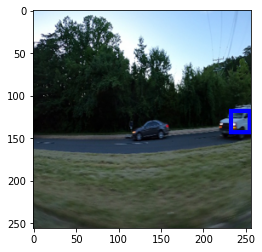

In [50]:
from torchvision.utils import draw_bounding_boxes
import torchvision

path = '/content/data/testing_images/vid_5_26700.jpg'
for  x_center, y_center, w, h in inference(path):
    tensor_image =  get_tensor_image_from_path(path).to(device)


    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=int)
    colors = ["blue"]
    int_tensor = (255 * tensor_image).type(torch.LongTensor)
    int_tensor = torchvision.transforms.ConvertImageDtype(torch.uint8)(tensor_image)

    result = draw_bounding_boxes(int_tensor, boxes, colors=colors, width=5)
    plt.imshow(result.permute(1,2,0));